#***data collection***

In [ ]:
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vinodhinibandaru","key":"11c4b5c95a897aeebd87679c0398b0a5"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d elinachen717/municipal-solid-waste-dataset

Dataset URL: https://www.kaggle.com/datasets/elinachen717/municipal-solid-waste-dataset
License(s): CC0-1.0
  0% 0.00/4.81M [00:00<?, ?B/s]
100% 4.81M/4.81M [00:00<00:00, 1.06GB/s]


In [ ]:
!unzip /content/municipal-solid-waste-dataset.zip

Archive:  /content/municipal-solid-waste-dataset.zip
  inflating: Dataset/Biodegradable Images/TEST_BIODEG_HFL_0.jpeg  
  inflating: Dataset/Biodegradable Images/TEST_BIODEG_HFL_1.jpeg  
  inflating: Dataset/Biodegradable Images/TEST_BIODEG_HFL_10.jpeg  
  inflating: Dataset/Biodegradable Images/TEST_BIODEG_HFL_100.jpeg  
  inflating: Dataset/Biodegradable Images/TEST_BIODEG_HFL_1000.jpeg  
  inflating: Dataset/Biodegradable Images/TEST_BIODEG_HFL_1004.jpeg  
  inflating: Dataset/Biodegradable Images/TEST_BIODEG_HFL_1005.jpeg  
  inflating: Dataset/Biodegradable Images/TEST_BIODEG_HFL_1007.jpeg  
  inflating: Dataset/Biodegradable Images/TEST_BIODEG_HFL_1008.jpeg  
  inflating: Dataset/Biodegradable Images/TEST_BIODEG_HFL_1009.jpeg  
  inflating: Dataset/Biodegradable Images/TRAIN.1_BIODEG_ORI_10035.jpg  
  inflating: Dataset/Biodegradable Images/TRAIN.2_BIODEG_ORI_10025.jpg  
  inflating: Dataset/Biodegradable Images/TRAIN.2_BIODEG_ORI_10043.jpg  
  inflating: Dataset/Biodegradable Im

In [ ]:
# Set the path to the dataset
dataset_dir = '/content/Dataset'
classes = os.listdir (dataset_dir)
# Create directories for train, val, and test sets
output_dir = 'output_dataset'
os.makedirs (output_dir, exist_ok=True)
os.makedirs (os.path.join(output_dir, 'train'), exist_ok=True)
os.makedirs (os.path.join(output_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test'), exist_ok=True)
for cls in classes:
    os.makedirs (os.path.join(output_dir, 'train', cls), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'val', cls), exist_ok=True)
    os.makedirs (os.path.join(output_dir, 'test', cls), exist_ok=True)
    class_dir = os.path.join(dataset_dir, cls)
    images = os.listdir(class_dir)
    print(cls, len(images))
    train_and_val_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    train_images, val_images = train_test_split(train_and_val_images, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2
# Copy images to respective directories
    for img in train_images:
          shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'train', cls, img))
    for img in val_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'val', cls, img))
    for img in test_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'test', cls, img))
print("Dataset split into training, validation, and test sets.")

Recyclable Images 130
Trash Images 130
Biodegradable Images 130
Dataset split into training, validation, and test sets.


In [ ]:
# Define directories
dataset_dir ='/content/output_dataset'
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')
# Define image size expected by the pre-trained model
IMG_SIZE = (224, 224) # Common size for many models like ResNet, VGG, MobileNet
# Create ImageDataGenerators for resizing and augmenting the images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator (rescale=1./255)
#Load and resize the images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary' # Assuming binary classification for healthy vs rotten
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    shuffle=False # Do not shuffle test data
)
    #Print class indices for reference
print(train_generator.class_indices)
print(val_generator.class_indices)
print(test_generator.class_indices)

Found 234 images belonging to 3 classes.
Found 78 images belonging to 3 classes.
Found 78 images belonging to 3 classes.
{'Biodegradable Images': 0, 'Recyclable Images': 1, 'Trash Images': 2}
{'Biodegradable Images': 0, 'Recyclable Images': 1, 'Trash Images': 2}
{'Biodegradable Images': 0, 'Recyclable Images': 1, 'Trash Images': 2}


#***data visualization***

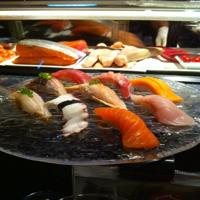

In [ ]:
import random
from IPython.display import Image, display
# Specify the path to your image folder
folder_path = '/content/output_dataset/train/Biodegradable Images'
# Replace with the actual path to your image folder
# List all files in the folder
image_files = [f for f in os.listdir (folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
# Select a random image from the list
selected_image = random.choice(image_files)
# Display the randomly selected image
image_path = os.path.join(folder_path, selected_image)
display (Image(filename=image_path))

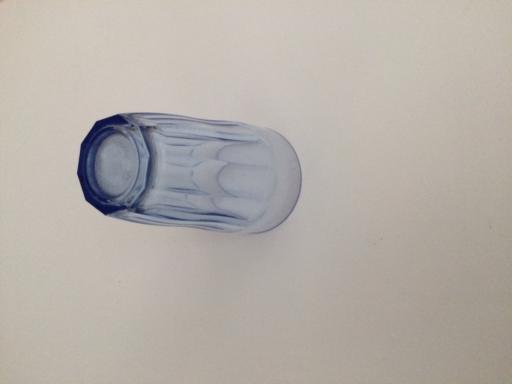

In [ ]:
folder_path = '/content/output_dataset/test/Recyclable Images'
# Replace with the actual path to your image folder
# List all files in the folder
image_files = [f for f in os.listdir (folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
# Select a random image from the list
selected_image = random.choice(image_files)
# Display the randomly selected image
image_path = os.path.join(folder_path, selected_image)
display(Image(filename=image_path))

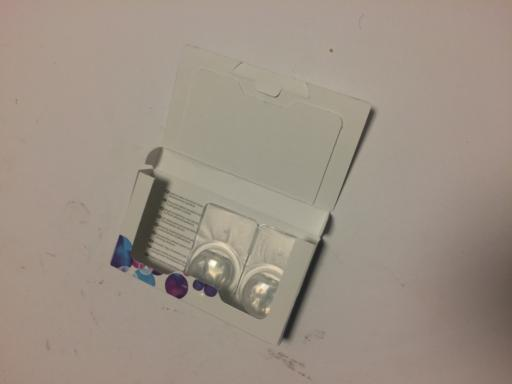

In [ ]:
folder_path = '/content/output_dataset/test/Trash Images' # Replace with the actual path to your image folder
# List all files in the folder
image_files = [f for f in os.listdir (folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
# Select a random image from the list
selected_image = random.choice(image_files)
# Display the randomly selected image
image_path = os.path.join(folder_path, selected_image)
display (Image(filename=image_path))

#***data splitting***

In [ ]:
trainpath = "/content/output_dataset/train"
testpath="/content/output_dataset/test"

In [ ]:
train_datagen = ImageDataGenerator (rescale = 1./255,zoom_range= 0.2, shear_range= 0.2)
test_datagen = ImageDataGenerator (rescale = 1./255)

In [ ]:
train = train_datagen.flow_from_directory (trainpath, target_size = (224, 224), batch_size = 20)
test = test_datagen.flow_from_directory (testpath, target_size = (224,224), batch_size = 20)

Found 234 images belonging to 3 classes.
Found 78 images belonging to 3 classes.


#***model building***

In [ ]:
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in vgg.layers:
    print(layer)

<InputLayer name=input_layer, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<MaxPooling2D name=block3_pool, built=True>
<Conv2D name=block4_conv1, built=True>
<Conv2D name=block4_conv2, built=True>
<Conv2D name=block4_conv3, built=True>
<MaxPooling2D name=block4_pool, built=True>
<Conv2D name=block5_conv1, built=True>
<Conv2D name=block5_conv2, built=True>
<Conv2D name=block5_conv3, built=True>
<MaxPooling2D name=block5_pool, built=True>


In [ ]:
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
x= Flatten()(vgg.output)

In [ ]:
output = Dense(3, activation = 'softmax')(x)

In [ ]:
vgg16 = Model(vgg.input,output)

In [ ]:
vgg16.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │        75,267 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,789,955 (56.42 MB)

 Trainable params: 75,267 (294.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)
# Assuming you have defined your VGG16 model as vgg16
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
# Compile the model (you may have already done this)
vgg16.compile(optimizer = 'Adam', loss='categorical_crossentropy', metrics=['accuracy'])
## Train the model with early stopping callback
history = vgg16.fit (train, validation_data=test,
                     epochs=10,
                     steps_per_epoch=5,
                     callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5007 - loss: 2.9247

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 72s 16s/step - accuracy: 0.5039 - loss: 2.9914 - val_accuracy: 0.6282 - val_loss: 1.4976
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 68s 16s/step - accuracy: 0.7156 - loss: 1.6779 - val_accuracy: 0.6282 - val_loss: 0.9026
Epoch 3/10
2/5 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.6625 - loss: 0.7356

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 10s/step - accuracy: 0.6700 - loss: 0.7033 - val_accuracy: 0.6410 - val_loss: 0.7393
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 87s 15s/step - accuracy: 0.6571 - loss: 0.7954 - val_accuracy: 0.6795 - val_loss: 0.6600
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 69s 16s/step - accuracy: 0.6871 - loss: 0.7644 - val_accuracy: 0.7564 - val_loss: 0.6062
Epoch 6/10
2/5 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.7625 - loss: 0.4271

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 47s 10s/step - accuracy: 0.7700 - loss: 0.4665 - val_accuracy: 0.7179 - val_loss: 0.7249
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 69s 15s/step - accuracy: 0.7918 - loss: 0.3603 - val_accuracy: 0.7821 - val_loss: 0.6229
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 66s 15s/step - accuracy: 0.8780 - loss: 0.2244 - val_accuracy: 0.7308 - val_loss: 0.5777
Epoch 9/10
2/5 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step - accuracy: 0.8375 - loss: 0.2706

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 45s 9s/step - accuracy: 0.8300 - loss: 0.2869 - val_accuracy: 0.7692 - val_loss: 0.6123
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 69s 15s/step - accuracy: 0.9461 - loss: 0.1944 - val_accuracy: 0.7564 - val_loss: 0.6521


# ***testing***

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
labels=[0,1,2]

# ***test-1***

In [ ]:
img_path='/content/output_dataset/train/Biodegradable Images/TEST_BIODEG_HFL_10.jpeg'

In [ ]:
import numpy as np
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = preprocess_input(x)
preds = vgg16.predict(np.array([x]))
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


array([[1., 0., 0.]], dtype=float32)

In [ ]:
labels[np.argmax(preds)]

0

# ***test-2***

In [ ]:
img_path='/content/output_dataset/test/Recyclable Images/cardboard102.jpeg'

In [ ]:
import numpy as np
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
X = preprocess_input(x)
preds = vgg16.predict(np.array([x]))
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


array([[2.6690871e-20, 1.0000000e+00, 2.2807331e-08]], dtype=float32)

In [ ]:
labels [np.argmax(preds)]

1

# ***test-3***

In [ ]:
img_path='/content/output_dataset/train/Trash Images/TRAIN.4_NBIODEG_CCW_2313.jpg'

In [ ]:
import numpy as np
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = preprocess_input(x)
preds = vgg16.predict(np.array([x]))
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


array([[5.4649018e-28, 2.5753153e-16, 1.0000000e+00]], dtype=float32)

In [ ]:
labels [np.argmax(preds)]

2

# ***test-4***

In [ ]:
img_path='/content/output_dataset/train/Recyclable Images/paper123.jpeg'

In [ ]:
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = preprocess_input(x)
preds = vgg16.predict(np.array([x]))
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


array([[5.6087155e-18, 6.9535676e-11, 1.0000000e+00]], dtype=float32)

In [ ]:
labels [np.argmax(preds)]

2

# ***save the model***

In [ ]:
vgg16.save('vgg16.h5')